Name : Budhaditya Mukhopadhyay (229960) 

# **TASK 3 : Transfer Learning**

In this task, you will implement different strategies on doing transfer learning.
You will also investigate how well transfer learning is applicable to inputs of different data distributions.

3.1 same distribution
Split the MNIST dataset, such that 7 classes are the source domain and the other 3 classes are the target domain.
Start with the source domain data set and train a model on it.
From the trained model, cut off the final classification layer and replace it with a new layer for the target domain classes. For now, keep all layers trainable.
Now train this model on the target domain data set. For comparison, also train a freshly initialized model on the target domain data set.

How well did the transfer learning work, compared to training on the target data set from scratch?
You can e.g. compare:

achieved accuracy
steps until convergence
generalization
3.2 different distribution
Now we will work with MNIST as source domain and FMNIST as target domain. (This is convenient, as they already have the same input shape.)
Similar to 3.1, first train a model on the MNIST and use the pre-trained model as initialization for a model trained on FMNIST.
Compare this transfer learned model with a model trained on FMNIST from scratch using the measures from 3.1.

Repeat the experiment with FMNIST as source and MNIST as target!
Does transfer learning work better or worse this time?

3.3 Compare diffferent ways to do the transfer learning
Transfer learning is done with different strategies.
You can for example investigate:

freezing all pre-trained layers (i.e. set trainable to False)
freezing only some bottom layers
replacing (or reinitializing) multiple top layers
replacing the source classification layer by multiple new ones for the target domain
This is particularly meaningful, if the target domain is more complex than the source domain.
Do you observe any differences in the final result using different ways of going from target to source?

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

In [ ]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
Y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## 3.1 same distribution

In [ ]:
# Domain Separation, i.e. [0,6] and [7,9]
d1_train_index = []
d1_test_index = []

d2_train_index = []
d2_test_index = []

for idx in range(len(Y_train)):
    if Y_train[idx] < 7:
        d1_train_index.append(idx)
    else:
        d2_train_index.append(idx)

for idx in range(len(Y_test)):
    if Y_test[idx] < 7:
        d1_test_index.append(idx)
    else:
        d2_test_index.append(idx)

# Domain 1
d1_train_x = X_train[d1_train_index]
d1_train_y = Y_train[d1_train_index]

d1_test_x = X_test[d1_test_index]
d1_test_y = Y_test[d1_test_index]


# Domain 2
d2_train_x = X_train[d2_train_index]
d2_train_y = Y_train[d2_train_index]-7

d2_test_x = X_test[d2_test_index]
d2_test_y = Y_test[d2_test_index]-7

# dataset.train_labels = dataset.train_labels[idx]
# dataset.train_data = dataset.train_data[idx]

In [ ]:
d1_dataset = tf.data.Dataset.from_tensor_slices(
    (d1_train_x.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, d1_train_y.astype(np.int32)))

d1_dataset = d1_dataset.shuffle(buffer_size = 40000).batch(128).repeat()

In [ ]:
d2_dataset = tf.data.Dataset.from_tensor_slices(
    (d2_train_x.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, d2_train_y.astype(np.int32)))

d2_dataset = d2_dataset.shuffle(buffer_size = 40000).batch(128).repeat()

3


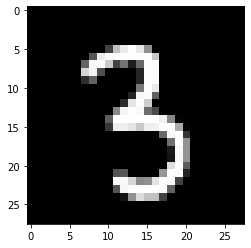

In [ ]:
print(d1_train_y[100])
plt.imshow(d1_train_x[100], cmap="Greys_r")

In [ ]:
train_steps = 1500

layer_list = [ tf.keras.layers.Conv2D(filters = 64,kernel_size=3,padding='same',activation=tf.nn.relu),
              tf.keras.layers.Conv2D(filters = 64,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
              tf.keras.layers.Dropout(0.25),
              
              tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
              tf.keras.layers.Dropout(0.25),
              
               tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
                    
              
              tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
              
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(7,activation='softmax')]  
model = tf.keras.Sequential(layer_list)

In [ ]:
opt = tf.optimizers.Adam(0.001)
# from_logits = True!! #neverforget
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (img_batch, lbl_batch) in enumerate(d1_dataset):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        # loss format is generally: first argument targets, second argument outputs
        xent = loss_fn(lbl_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: 1.945624589920044 Accuracy: 0.2421875
Loss: 1.1979749202728271 Accuracy: 0.6174218654632568
Loss: 1.1753778457641602 Accuracy: 0.9644531011581421
Loss: 1.177947998046875 Accuracy: 0.9735156297683716
Loss: 1.180203914642334 Accuracy: 0.978903591632843
Loss: 1.1732628345489502 Accuracy: 0.9769531488418579
Loss: 1.2030490636825562 Accuracy: 0.9784374833106995
Loss: 1.1816561222076416 Accuracy: 0.9808642268180847
Loss: 1.2110333442687988 Accuracy: 0.9767187237739563
Loss: 1.1813955307006836 Accuracy: 0.9825000166893005
Loss: 1.2513420581817627 Accuracy: 0.9767076969146729
Loss: 1.2045217752456665 Accuracy: 0.9669530987739563
Loss: 1.1810489892959595 Accuracy: 0.9649999737739563
Loss: 1.3284459114074707 Accuracy: 0.9516406059265137
Loss: 1.2201097011566162 Accuracy: 0.953807532787323
Loss: 1.1732347011566162 Accuracy: 0.948437511920929


Changing the Last Layer

Training on target domain dataset

In [ ]:
layers_minus_softmax = model.layers[-2].output
output_with_replaced_softmax_layer = tf.keras.layers.Dense(3, activation='softmax')(layers_minus_softmax)
model = Model(inputs=model.inputs, outputs=output_with_replaced_softmax_layer)

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (img_batch, lbl_batch) in enumerate(d2_dataset):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        # loss format is generally: first argument targets, second argument outputs
        xent = loss_fn(lbl_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: 1.2613710165023804 Accuracy: 0.2890625
Loss: 1.23113214969635 Accuracy: 0.3492187559604645
Loss: 1.20769464969635 Accuracy: 0.34139806032180786
Loss: 1.21550714969635 Accuracy: 0.3487272560596466
Loss: 1.21550714969635 Accuracy: 0.34867188334465027
Loss: 1.23113214969635 Accuracy: 0.3450232446193695
Loss: 1.23113214969635 Accuracy: 0.34904247522354126
Loss: 1.19988214969635 Accuracy: 0.34468749165534973
Loss: 1.21550714969635 Accuracy: 0.34967294335365295
Loss: 1.18425714969635 Accuracy: 0.3443927764892578
Loss: 1.19988214969635 Accuracy: 0.3498305678367615
Loss: 1.19988214969635 Accuracy: 0.34351563453674316
Loss: 1.22331964969635 Accuracy: 0.3456537127494812
Loss: 1.16081964969635 Accuracy: 0.3452596664428711
Loss: 1.20769464969635 Accuracy: 0.34812501072883606
Loss: 1.20769464969635 Accuracy: 0.3508550822734833


### Observation for 3.1

How well did the transfer learning work, compared to training on the target data set from scratch?

Ans - It did not perform that well, we are getting an accuracy of 35%. 

## 3.2 Different Distribution

Source domain = MNIST target domain= Fashion MNIST

In [ ]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
data = tf.data.Dataset.from_tensor_slices(
    (X_train.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, Y_train.astype(np.int32)))

data1 = data.shuffle(buffer_size = 40000).batch(128).repeat()

In [ ]:
train_steps = 1500

layer_list = [ tf.keras.layers.Conv2D(filters = 64,kernel_size=3,padding='same',activation=tf.nn.relu),
              tf.keras.layers.Conv2D(filters = 64,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
              tf.keras.layers.Dropout(0.5),
              
              tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
              tf.keras.layers.Dropout(0.25),
              
               tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
                    
              
              tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
              
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(7,activation='softmax')]  
model = tf.keras.Sequential(layer_list)

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (img_batch, lbl_batch) in enumerate(data1):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        # loss format is generally: first argument targets, second argument outputs
        xent = loss_fn(lbl_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: nan Accuracy: 0.15625
Loss: nan Accuracy: 0.10195312649011612
Loss: nan Accuracy: 0.09593749791383743
Loss: nan Accuracy: 0.10101562738418579
Loss: nan Accuracy: 0.09742187708616257
Loss: nan Accuracy: 0.09727443754673004
Loss: nan Accuracy: 0.09851562231779099
Loss: nan Accuracy: 0.099609375
Loss: nan Accuracy: 0.09546875208616257
Loss: nan Accuracy: 0.10296875238418579
Loss: nan Accuracy: 0.09946741908788681
Loss: nan Accuracy: 0.09554687142372131
Loss: nan Accuracy: 0.09898437559604645
Loss: nan Accuracy: 0.10296875238418579
Loss: nan Accuracy: 0.09515625238418579
Loss: nan Accuracy: 0.0973527580499649


In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
data = tf.data.Dataset.from_tensor_slices(
    (X_train.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, Y_train.astype(np.int32)))

data2 = data.shuffle(buffer_size = 40000).batch(128).repeat()

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (img_batch, lbl_batch) in enumerate(data2):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        # loss format is generally: first argument targets, second argument outputs
        xent = loss_fn(lbl_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: nan Accuracy: 0.09375
Loss: nan Accuracy: 0.0949999988079071
Loss: nan Accuracy: 0.09976562857627869
Loss: nan Accuracy: 0.10187499970197678
Loss: nan Accuracy: 0.09968750178813934
Loss: nan Accuracy: 0.0958646610379219
Loss: nan Accuracy: 0.09734375029802322
Loss: nan Accuracy: 0.09726562350988388
Loss: nan Accuracy: 0.10398437827825546
Loss: nan Accuracy: 0.09929687529802322
Loss: nan Accuracy: 0.0943765640258789
Loss: nan Accuracy: 0.10289062559604645
Loss: nan Accuracy: 0.09617187827825546
Loss: nan Accuracy: 0.10046874731779099
Loss: nan Accuracy: 0.09734375029802322
Loss: nan Accuracy: 0.09555137902498245


Source domain =Fashion  MNIST target domain= MNIST

In [ ]:
#Source domain =Fashion  MNIST target domain= MNIST
train_steps = 1500

layer_list = [ tf.keras.layers.Conv2D(filters = 64,kernel_size=3,padding='same',activation=tf.nn.relu),
              tf.keras.layers.Conv2D(filters = 64,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
              tf.keras.layers.Dropout(0.5),
              
              tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
              tf.keras.layers.Dropout(0.25),
              
               tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
                    
              
              tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation=tf.nn.relu),
               tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
              
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(7,activation='softmax')]  
model = tf.keras.Sequential(layer_list)

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (img_batch, lbl_batch) in enumerate(data2):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        # loss format is generally: first argument targets, second argument outputs
        xent = loss_fn(lbl_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: nan Accuracy: 0.1015625
Loss: nan Accuracy: 0.09726562350988388
Loss: nan Accuracy: 0.10257812589406967
Loss: nan Accuracy: 0.09765625
Loss: nan Accuracy: 0.09515625238418579
Loss: nan Accuracy: 0.1005639061331749
Loss: nan Accuracy: 0.09992187470197678
Loss: nan Accuracy: 0.10046874731779099
Loss: nan Accuracy: 0.10109374672174454
Loss: nan Accuracy: 0.09632812440395355
Loss: nan Accuracy: 0.09547305852174759
Loss: nan Accuracy: 0.09742187708616257
Loss: nan Accuracy: 0.09945312142372131
Loss: nan Accuracy: 0.09648437798023224
Loss: nan Accuracy: 0.10148437321186066
Loss: nan Accuracy: 0.1011904776096344


In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (img_batch, lbl_batch) in enumerate(data1):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        # loss format is generally: first argument targets, second argument outputs
        xent = loss_fn(lbl_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: nan Accuracy: 0.09375
Loss: nan Accuracy: 0.09749999642372131
Loss: nan Accuracy: 0.09851562231779099
Loss: nan Accuracy: 0.09828124940395355
Loss: nan Accuracy: 0.1003125011920929
Loss: nan Accuracy: 0.09750939905643463
Loss: nan Accuracy: 0.09820312261581421
Loss: nan Accuracy: 0.09703125059604645
Loss: nan Accuracy: 0.10359375178813934
Loss: nan Accuracy: 0.09929687529802322
Loss: nan Accuracy: 0.0988408550620079
Loss: nan Accuracy: 0.09656249731779099
Loss: nan Accuracy: 0.09687499701976776
Loss: nan Accuracy: 0.10164062678813934
Loss: nan Accuracy: 0.09937500208616257
Loss: nan Accuracy: 0.09656954556703568


### Observation for 3.2


Transfer learning performs worse in this case

## 3.3 Compare diffferent ways to do the transfer learning

Source domain = MNIST target domain= Fashion MNIST

### Freezing all Layers

In [ ]:
for layer in model.layers:
	layer.trainable = False

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (img_batch, lbl_batch) in enumerate(data1):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        # loss format is generally: first argument targets, second argument outputs
        xent = loss_fn(lbl_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: nan Accuracy: 0.140625
Loss: nan Accuracy: 0.09468749910593033
Loss: nan Accuracy: 0.09765625
Loss: nan Accuracy: 0.10265625268220901
Loss: nan Accuracy: 0.09726562350988388
Loss: nan Accuracy: 0.09805764257907867
Loss: nan Accuracy: 0.09828124940395355
Loss: nan Accuracy: 0.09820312261581421
Loss: nan Accuracy: 0.09914062172174454
Loss: nan Accuracy: 0.09953124821186066
Loss: nan Accuracy: 0.10087719559669495
Loss: nan Accuracy: 0.09734375029802322
Loss: nan Accuracy: 0.10187499970197678
Loss: nan Accuracy: 0.099609375
Loss: nan Accuracy: 0.09757812321186066
Loss: nan Accuracy: 0.09656954556703568


### Freezing the Top Layers

In [ ]:
for layer in model.layers[:-3]:
	layer.trainable = False

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (img_batch, lbl_batch) in enumerate(data1):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        # loss format is generally: first argument targets, second argument outputs
        xent = loss_fn(lbl_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: nan Accuracy: 0.0859375
Loss: nan Accuracy: 0.09828124940395355
Loss: nan Accuracy: 0.10429687798023224
Loss: nan Accuracy: 0.09742187708616257
Loss: nan Accuracy: 0.09234374761581421
Loss: nan Accuracy: 0.09876253455877304
Loss: nan Accuracy: 0.1003125011920929
Loss: nan Accuracy: 0.10398437827825546
Loss: nan Accuracy: 0.09875000268220901
Loss: nan Accuracy: 0.09609375149011612
Loss: nan Accuracy: 0.0958646610379219
Loss: nan Accuracy: 0.10007812827825546
Loss: nan Accuracy: 0.09882812201976776
Loss: nan Accuracy: 0.09984374791383743
Loss: nan Accuracy: 0.09664062410593033
Loss: nan Accuracy: 0.09766604006290436


### Freezing the Bottom Layers

In [ ]:
for layer in model.layers[-3:-1]:
	layer.trainable = False

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (img_batch, lbl_batch) in enumerate(data1):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        # loss format is generally: first argument targets, second argument outputs
        xent = loss_fn(lbl_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: nan Accuracy: 0.078125
Loss: nan Accuracy: 0.10117187350988388
Loss: nan Accuracy: 0.10171875357627869
Loss: nan Accuracy: 0.09882812201976776
Loss: nan Accuracy: 0.09476562589406967
Loss: nan Accuracy: 0.09602130204439163
Loss: nan Accuracy: 0.09789062291383743
Loss: nan Accuracy: 0.09726562350988388
Loss: nan Accuracy: 0.09757812321186066
Loss: nan Accuracy: 0.10273437201976776
Loss: nan Accuracy: 0.10087719559669495
Loss: nan Accuracy: 0.09687499701976776
Loss: nan Accuracy: 0.10007812827825546
Loss: nan Accuracy: 0.10187499970197678
Loss: nan Accuracy: 0.09398437291383743
Loss: nan Accuracy: 0.1005639061331749


### Observation for 3.3
After freezing all the layers we can see that the accuracy has reached down to 9.65%

Freezing the top layer gives us an accuracy of 9.7%

Freezing the bottom layer gives us as accuracy of 10%

